# Intelligent Systems 3: Probabilistic and Deep Learning
#### Exam number:

In [2]:
import math

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import lstsq
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, ElasticNetCV
from sklearn.linear_model import RidgeCV, LinearRegression, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, SplineTransformer
import seaborn as sn
import torch
import torch.nn as nn
import os
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from skimage import io,transform


In [ ]:
def plot_model(model, x_test, y_test):
    prediction = model.predict(x_test)
    true_value = y_test.iloc[0]
    predicted_value = prediction[0]
    print(f"Next True value: {true_value} Next predicted value: {predicted_value} Relative Error: {abs((predicted_value-true_value)/true_value)*100}%")
    plt.figure(figsize=(10,5))
    plt.scatter(target.index, target)
    plt.plot(target.index, target, color="black")
    plt.scatter(y_test.index,prediction, color="green")
    plt.show()


# 1 Using Regression

## Data Exploration

#### Plotted Data

In [ ]:
df = pd.read_csv("data.csv")

In [ ]:
df

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df.index, df)
plt.legend(df.columns)
plt.show()

From plotting the data its quite east to see that there is a visible correlation between B, C and D.

In [ ]:
corrMatrix = df.diff().corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

We can see that there is a relatively strong correlation between D and C but besides that there do not appear to be strongly correlated features

## Basic Regression
This is regression applied to the variables A, B, C and D(Time Lagged)

In [ ]:
def preprocess_data(location,time_lag):
    df = pd.read_csv(location)
    target = df["D"].copy()
    df["D"] = target.shift(1)
    for index, columns in enumerate(["A", "B", "C", "D"]):
        for i in range(time_lag+1):
            df[f"{columns}_Lag_{i}"] = df[columns].shift(i)
    df = df.dropna()
    df.drop(["A","B","C","D"],axis=1,inplace=True)
    target = target.iloc[time_lag+1:]

    return df,target

In [ ]:
df , target = preprocess_data("data.csv",0)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df,target,shuffle=False,test_size=24)

In [ ]:
model = LinearRegression()

In [ ]:
model.fit(x_train,y_train)

In [ ]:
r2_score(y_test, model.predict(x_test))

In [ ]:
model.coef_

In [ ]:
plot_model(model,x_test,y_test)

### Time Laggged Linear Regression

In [ ]:
df, target = preprocess_data("data.csv",4)

The code cell below adds time lag to the dataset. By default the shift function deletes data, but there are options to fill the deleted data wih any given value. At first I attempted to duplicate the first known value but this did not improve accuracy.So I the rows with the NaN values are dropped. Because of this approach I should take care with the amount of time units I shift by, otherwise many rows will be dropped

Data is split into a 2 sets, the training set and the testing set. Since the Data is time series, I will not be shuffling any of the data. The temporal order in the dataset is always maintained

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df,target,shuffle=False,test_size=24)

In [ ]:
model = LinearRegression()

In [ ]:
model.fit(x_train,y_train)

In [ ]:
r2_score(y_test, model.predict(x_test))

In [ ]:
plot_model(model,x_test,y_test)

### Regularisation

Regularisation is the process of adding a penalty function to model. In the real world its very rare that data exists with no noise, so regularisation is a tool that can be used to decrease the likelyhood of the model overfitting and therefore generalising better


In [ ]:
df, target = preprocess_data("data.csv",0)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df,target,shuffle=False,test_size=25)

In [ ]:
myalphas = np.logspace(-6, 6, 13)

#### Ridge Regression
Ridge Regression is most effective when the features are highly correlated. This is called multicolinearity.

In [ ]:
model = RidgeCV()

In [ ]:
ridge_reg = model.fit(x_train,y_train)

In [ ]:
r2_score(y_test, ridge_reg.predict(x_test))

In [ ]:
plot_model(ridge_reg,x_test,y_test)

#### Lasso Regression

In [ ]:
model = LassoCV(alphas=myalphas)

In [ ]:
lasso_reg = model.fit(x_train,y_train)

In [ ]:
r2_score(y_test, lasso_reg.predict(x_test))

In [ ]:
plot_model(lasso_reg,x_test,y_test)

#### Elastic Net Regression

In [ ]:
model = ElasticNetCV()

In [ ]:
elastic_reg = model.fit(x_train, y_train)

In [ ]:
r2_score(y_test, elastic_reg.predict(x_test))

In [ ]:
plot_model(elastic_reg, x_test, y_test)

## Polynomial Regression

In [ ]:
df, target = preprocess_data("data.csv",0)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df,target,shuffle=False,test_size=60)

In [ ]:
model = make_pipeline(PolynomialFeatures(3),RidgeCV())

In [ ]:
poly_regression = model.fit(x_train, y_train)

In [ ]:
r2_score(y_test, poly_regression.predict(x_test))

In [ ]:
plot_model(poly_regression,x_test,y_test)

## Piecewise Regression

In [ ]:
df, target = preprocess_data("data.csv",0)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.tail(100),target.tail(100),shuffle=False,test_size=10)

In [ ]:
ramp = lambda u: np.maximum( u, 0 )
step = lambda u: ( u > 0 ).astype(float)

In [ ]:
def SegmentedLinearReg( X, Y, breakpoints ):
    nIterationMax = 10

    breakpoints = np.sort( np.array(breakpoints) )

    dt = np.min( np.diff(X) )
    ones = np.ones_like(X)

    for i in range( nIterationMax ):
        # Linear regression:  solve A*p = Y
        Rk = [ramp( X - xk ) for xk in breakpoints ]
        Sk = [step( X - xk ) for xk in breakpoints ]
        A = np.array([ ones, X ] + Rk + Sk )
        p =  lstsq(A.transpose(), Y, rcond=None)[0]

        # Parameters identification:
        a, b = p[0:2]
        ck = p[ 2:2+len(breakpoints) ]
        dk = p[ 2+len(breakpoints): ]

        # Estimation of the next break-points:
        newBreakpoints = breakpoints - dk/ck

        # Stop condition
        if np.max(np.abs(newBreakpoints - breakpoints)) < dt/5:
            break

        breakpoints = newBreakpoints
    else:
        print( 'maximum iteration reached' )

    # Compute the final segmented fit:
    Xsolution = np.insert( np.append( breakpoints, max(X) ), 0, min(X) )
    ones =  np.ones_like(Xsolution)
    Rk = [ c*ramp( Xsolution - x0 ) for x0, c in zip(breakpoints, ck) ]

    Ysolution = a*ones + b*Xsolution + np.sum( Rk, axis=0 )

    return Xsolution, Ysolution

In [ ]:
plt.plot( x_train.index, y_train, 'ok' );
plt.scatter(y_test.index, y_test,color="blue")
initialBreakpoints = [140,200]
#Try also with 3 breakpoints, e.g. [3,5,6]
model_prediction = SegmentedLinearReg( x_train.index, y_train, initialBreakpoints )
plt.plot( *model_prediction, '-r' );
plt.xlabel('X'); plt.ylabel('Y');

## Spline Interpolation

In [ ]:
df , target = preprocess_data("data.csv",0)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df,target,shuffle=False,test_size=40)

In [ ]:
spline_model = make_pipeline(SplineTransformer(n_knots=3,degree=3),LinearRegression())

In [ ]:
spline_model.fit(x_train,y_train)

In [ ]:
r2_score(y_test, spline_model.predict(x_test))

In [ ]:
plot_model(spline_model,x_test, y_test)

## Final Solution - Test Data Demonstration

For my final soloution, I am attempting to combine the most effective techniques (in terms of r_2)

In [ ]:
myalphas = np.logspace(-6, 6, 13)

In [ ]:
df,target = preprocess_data("data.csv",4)

In [ ]:
scaler = StandardScaler()
scaled = scaler.fit_transform(df)
df = pd.DataFrame(scaled, columns=df.columns)

In [ ]:
df

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df,target,shuffle=False,test_size=24)

In [ ]:
model = make_pipeline(RidgeCV())

In [ ]:
model.fit(x_train,y_train)

In [ ]:
r2_score(y_test, model.predict(x_test))

In [ ]:
plot_model(model,x_test,y_test)

## Final Solution - Markers Evaluation

Here is my final solution to be executed with the unseen data set, I am assuming the dataset is a csv file in the same directory as this notebook

In [ ]:
df, target = preprocess_data("unseen.csv",4)
scaler = StandardScaler()
scaled = scaler.fit_transform(df)
df = pd.DataFrame(scaled, columns=df.columns)
print(f" R_2 score: {r2_score(target, model.predict(df))}")
plot_model(model,df,target)

In the plot above, the green points are generated by my model, where are the blue points represent the data in unseen.csv

# 2. Descriptive statistics and dimensionality reduction

In [ ]:
pca = PCA(n_components=12,svd_solver = 'full')

In [ ]:
pca.fit(df)

In [ ]:
pca_df = pd.DataFrame(pca.fit_transform(df))

In [ ]:
df.var(axis=0).sort_values(ascending=False)

In [ ]:
print(f"Total Variance for normal data: {pd.Series(df.var(axis=0)).sum()}")

In [ ]:
print(f"Total Variance for PCA data: {pca_df.var(axis=0).sum()}")

## 1.2 PCA Calulation

### Steps
1. Centre Matrix
2. Calculate the covariance matrix
3. Calculate eigenvectors & eigenvalues of the covariance matrix
4. Select the first n eigenvectors


In [ ]:
mean_df = np.mean(df.T,axis=1)

In [ ]:
centre =df - mean_df

In [ ]:
covariance = np.cov(df.T)

In [ ]:
centre

In [ ]:
covariance

In [ ]:
eigenvalues,eigenvectors = np.linalg.eig(covariance)

In [ ]:
idx = eigenvalues.argsort()[::-1]

In [ ]:
eigenvalues = eigenvalues[idx]

In [ ]:
eigenvectors = eigenvectors[:,idx]

In [ ]:
principals = eigenvectors.T.dot(centre.T)

In [ ]:
principals.T[:,0:4]

In [ ]:
pca.components_

# 3. Predicting light source direction from face images with a CNN
For this question, I am approaching the problem as a classification problem. The main reason I am doing this is because It is known that there are 64 possible classes for the data. This means that even though one of the camera angles may not be correct, if the error is low in the classification. I can be confident that whatever group I classify the point as, it will be in close proximity to the true value

In [11]:
df = pd.read_csv("deeplearning/train/labels.csv",header=None)

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
le = LabelEncoder()

In [13]:
def show_face(image, camera_position):
    """Show image with landmarks"""
    plt.title(camera_position)
    plt.imshow(image,cmap="gray")
    plt.pause(0.001)  # pause a bit so that plots are updated

Since I am taking the approach of classification. I first create a string that is a concattenation of all the values of each compnent of the vector. I add a comma between them so I can use them to delimit the components after the classification. Finally I use a label encoder to transform these in 64 integers, representing each camera location

In [14]:
def encode_dataframe(df):
    df[4] = df[1].astype(str) + "," + df[2].astype(str) +","+ df[3].astype(str)
    df[4]  = le.fit_transform(df[4])
    return df

In the code cell below I have created a FaceDataset class that inherits from the pytorch library. It takes in the csv file an the image directory as arguments.

I read the image and resize it to a 160x160 image, I wanted to use an image as large as possible so features are as pronoucned as possible allowing filters to detect them more strongly.

In [33]:
class FaceDataset(Dataset):
    """Custom Fashion MNIST dataset."""

    def __init__(self, csv_file, image_dir,):
        self.labels_df = pd.read_csv(csv_file,header=None)
        self.labels_df = encode_dataframe(self.labels_df)
        self.transform = transform
        self.image_dir = image_dir

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.image_dir,
                                self.labels_df.iloc[idx, 0])
        image = io.imread(img_name, as_gray=True)
        image = transform.resize(image,(160,160))
        convert_tensor = transforms.ToTensor()
        image = convert_tensor(image)
        image.unsqueeze(0)
        camera_position = torch.tensor(self.labels_df.iloc[idx, 4])
        camera_position =  camera_position.type(torch.LongTensor)





        return image.float(), camera_position,img_name

Here I load in the labels for the data and then pass them through my encoding function.The outputted dataframe shows the encodings of the various camera positions in col 4

In [16]:
df2 = pd.read_csv("deeplearning/train/labels.csv",header=None)

In [17]:
encode_dataframe(df2).sort_values(by=4)

0         1         2    3   4
249   0250.jpg -0.087156 -0.996195  0.0   0
937   0938.jpg -0.087156 -0.996195  0.0   0
1703  1704.jpg -0.087156 -0.996195  0.0   0
313   0314.jpg -0.087156 -0.996195  0.0   0
1127  1128.jpg -0.087156 -0.996195  0.0   0
...        ...       ...       ...  ...  ..
1518  1519.jpg  1.000000  0.000000  0.0  63
1070  1071.jpg  1.000000  0.000000  0.0  63
1134  1135.jpg  1.000000  0.000000  0.0  63
1582  1583.jpg  1.000000  0.000000  0.0  63
0     0001.jpg  1.000000  0.000000  0.0  63

[1838 rows x 5 columns]

Here I'm using a batch size of 32. The dataset isn't too large so I could use a smaller batch size, but I was happy with the performance of my model so I kept it as is

In [18]:
batch_size=32

In [19]:
train_dataset = FaceDataset(csv_file='deeplearning/train/labels.csv',
                            image_dir='deeplearning/train')

In [20]:
test_dataset = FaceDataset(csv_file='deeplearning/validate/labels.csv',
                           image_dir='deeplearning/validate')

In [21]:
train_split, validation_split = random_split(train_dataset,[1470,368])

In [22]:
train_dataloader = DataLoader(train_split, batch_size=batch_size,
                              shuffle=True, num_workers=0)

In [23]:
validation_dataloader = DataLoader(validation_split, batch_size=batch_size,
                                   shuffle=True, num_workers=0)

In [24]:
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                             shuffle=False, num_workers=0)

In [28]:
def label_decode(label):
    temp = le.inverse_transform(label)
    temp = temp.reshape(1,-1).flatten()
    temp = temp[0].split(",")

    return torch.tensor(np.array(temp).astype(float))

In [ ]:
def angular_error(output,label):
    total_error  = 0
    for output_val,predic_val in zip(map(label_decode,[ [x] for x in output]),map(label_decode,[[x] for x in label])):
        total_error += torch.acos(torch.min(torch.tensor(1),torch.max(torch.tensor(-1),torch.dot(output_val,predic_val))))
    return torch.rad2deg(total_error)

The neural network is composed of 3 blocks of Convolutional, Batch Norm and Maxpool layers followed by a MLP.

A convolutional neural network is used because: "Insert why CNN's are good"
Batchnorm is used to make neural networks stable. The input data of the next layer is normalsied, this means that the gradient decent algorithm will converge faster as the loss function is smoothed. It also debated that Batch Normalisation reduces internal covariant shift.

In [30]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.convlayers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(6),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2), # B x 6 x 80 x 80 after this maxpool
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout(0.1),


            nn.MaxPool2d(kernel_size=2, stride=4), # B x 12 x20 x 20,
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=0),# B x 48 x 18x 18,
            nn.BatchNorm2d(24),
            nn.ReLU()



        )

        self.MLP = nn.Sequential(
            nn.Linear(in_features=24*18*18,out_features=120),
            nn.BatchNorm1d(120),
            nn.ReLU(),
            nn.Linear(in_features=120,out_features=84),
            nn.BatchNorm1d(84),
            nn.ReLU(),
            nn.Linear(in_features=84,out_features=64)
        )

    def forward(self, x):
        # Input x has dimensions B x 1 x 28 x 28, B is batch size
        x = self.convlayers(x)
        x = x.view(x.size(0), -1)
        x = self.MLP(x)
        # Output has dimensions B x 10
        return x

model = CNN()
model.to(device)
loss_func = nn.CrossEntropyLoss()

Here is an additional description of the model

In [ ]:
print(model)

In [ ]:
num_epochs = 25
learning_rate =0.01

### Training Code

In [ ]:


# Set up the optimiser
optim = torch.optim.Adam(model.parameters(), lr = learning_rate)
images,labels, _= next(iter(train_dataloader))
# Initialise some variables for computing and tracking stats
iterations_per_epoch = math.ceil(len(train_dataset)/batch_size)
training_losses = []
training_accuracies = []
validation_losses = []
validation_accuracies = []
for epoch in range(num_epochs):

    # One epoch on the training set
    total_loss = 0
    correct = 0
    total = 0
    total_loss = 0
    angle_error = 0
    for i, (inputs, labels,_) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        output = model(inputs)
        loss = loss_func(output,labels)
        optim.zero_grad()
        loss.backward()
        optim.step()
        pred_y = torch.argmax(output, 1)
        angle_error += angular_error(pred_y.to("cpu"),labels.to("cpu"))
        correct += (pred_y == labels).sum()
        total += float(labels.size(0))
        total_loss += loss*images.shape[0]
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Iteration [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, iterations_per_epoch, loss.item()))
    total_loss /= len(train_dataset)
    training_losses.append(total_loss.item())
    training_accuracies.append(correct/total)
    print('Train accuracy over epoch {}: {:.4f}'.format(epoch+1,training_accuracies[-1]))
    print(f"Mean Angular Error ={angle_error/len(train_dataset)}")

    # One epoch on the validation set
    correct = 0
    total = 0
    # Switch to evaluation mode
    model.eval()
    with torch.no_grad():
        for inputs, labels,_ in validation_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            loss = loss_func(output,labels)
            pred_y = torch.argmax(output, 1)
            correct += (pred_y == labels).sum()
            total += float(labels.size(0))
            total_loss += loss*images.shape[0]
        validation_accuracy = correct/total
    total_loss /= len(validation_split)
    validation_losses.append(total_loss.item())
    # Switch back to training mode
    model.train()
    validation_accuracies.append(validation_accuracy)
    print('Test accuracy at epoch {}: {:.4f}'.format(epoch+1,validation_accuracy))

In [ ]:
plt.title("Training curve")
plt.plot(range(len(training_losses)),training_losses,'r')
plt.plot(range(len(validation_losses)),validation_losses,'g')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

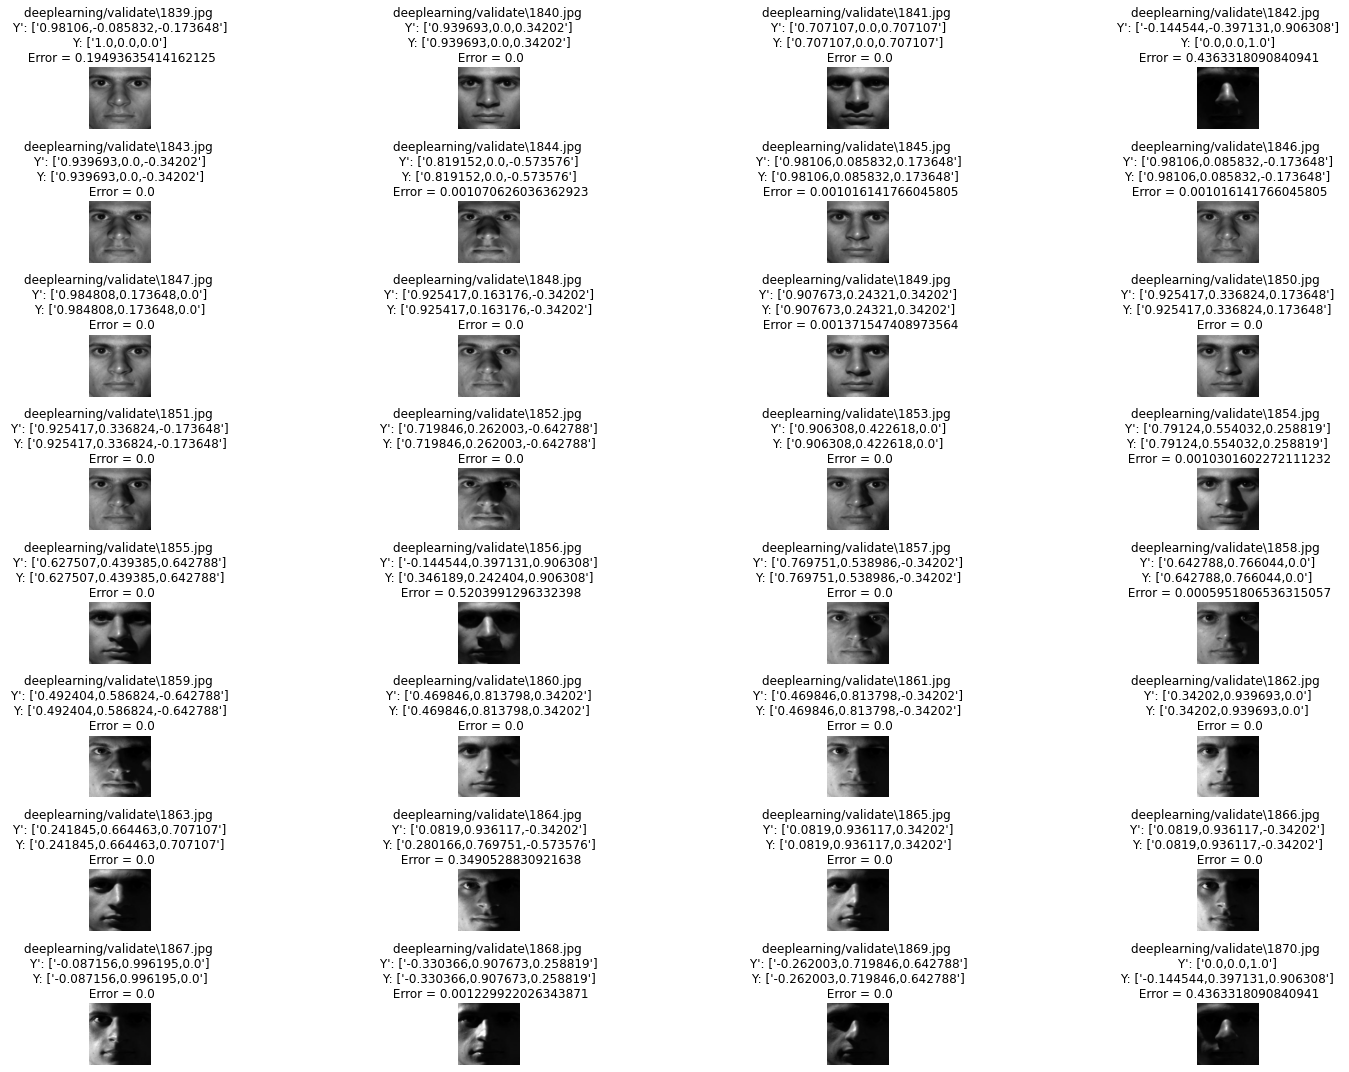

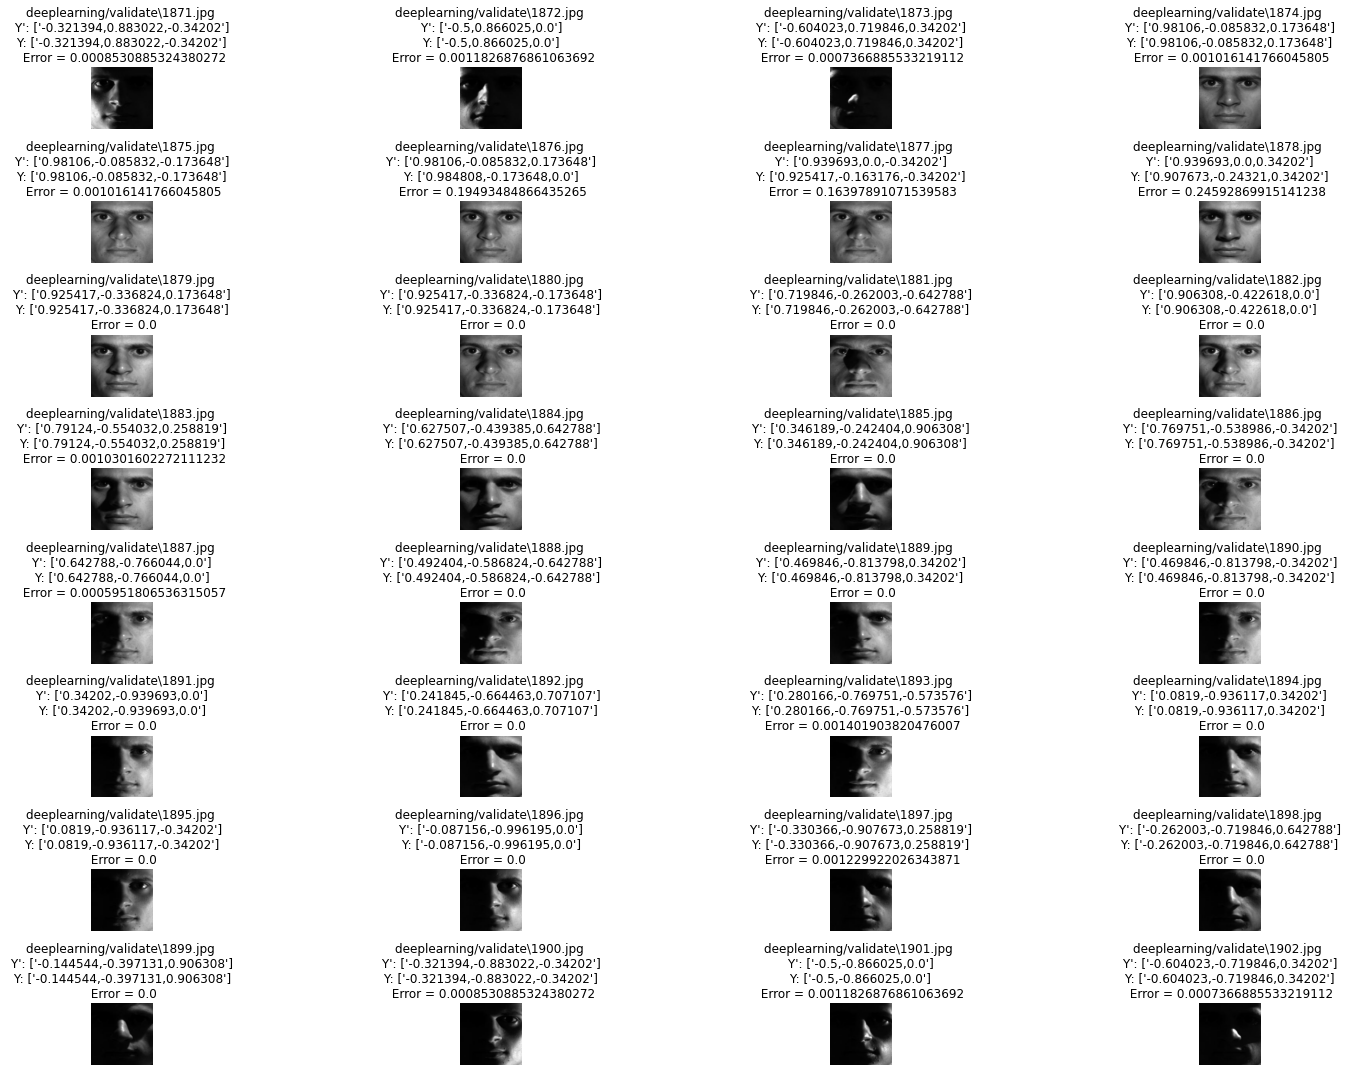

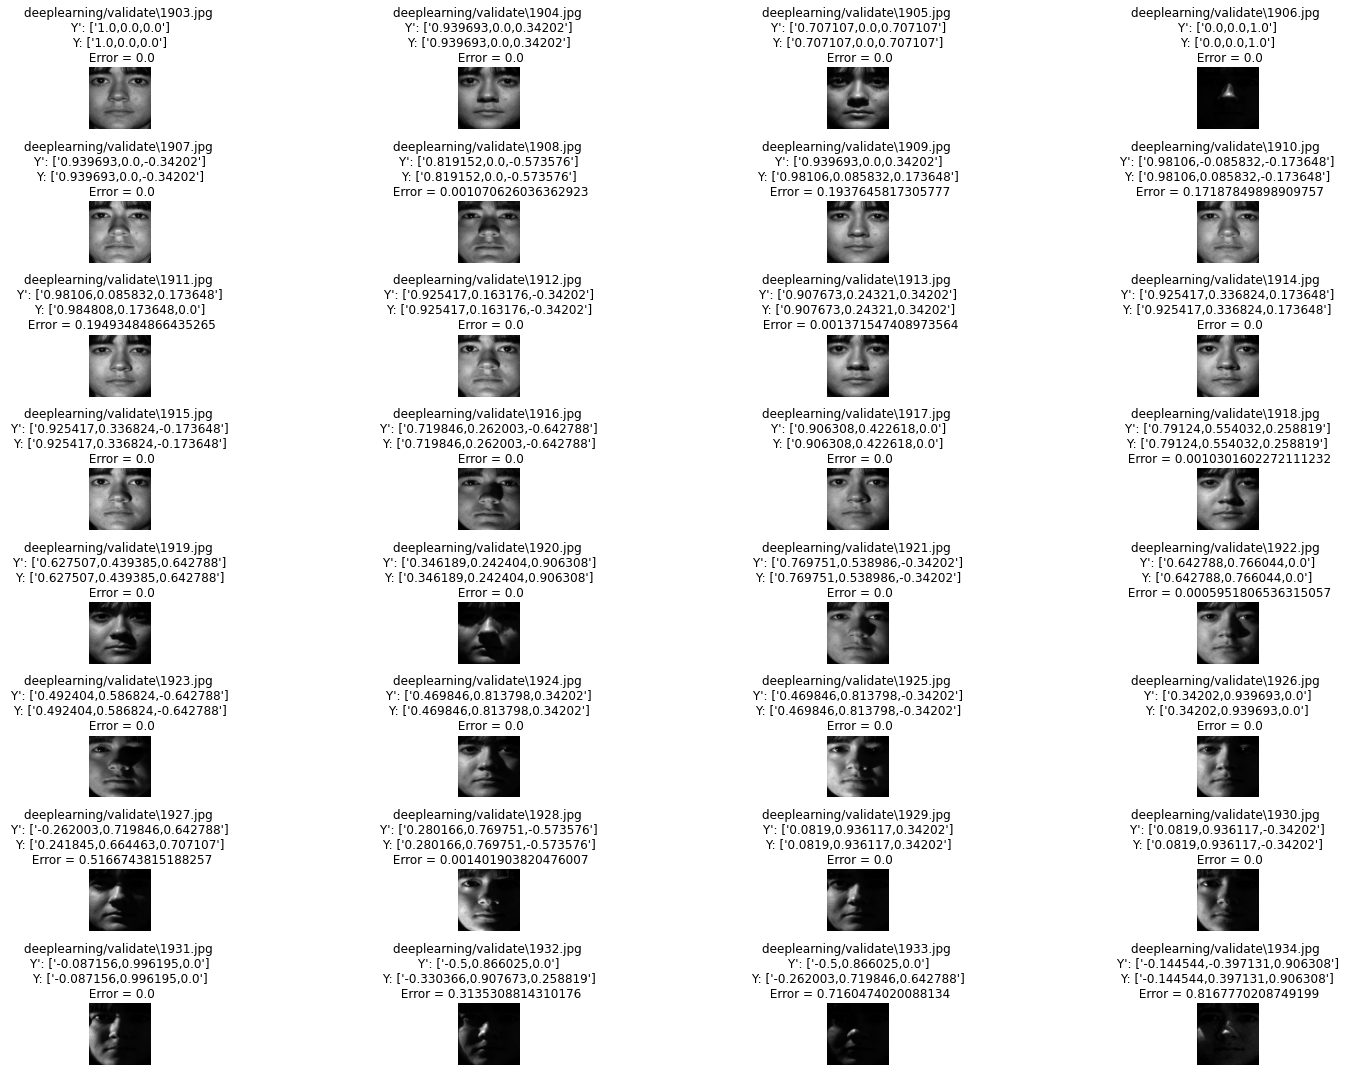

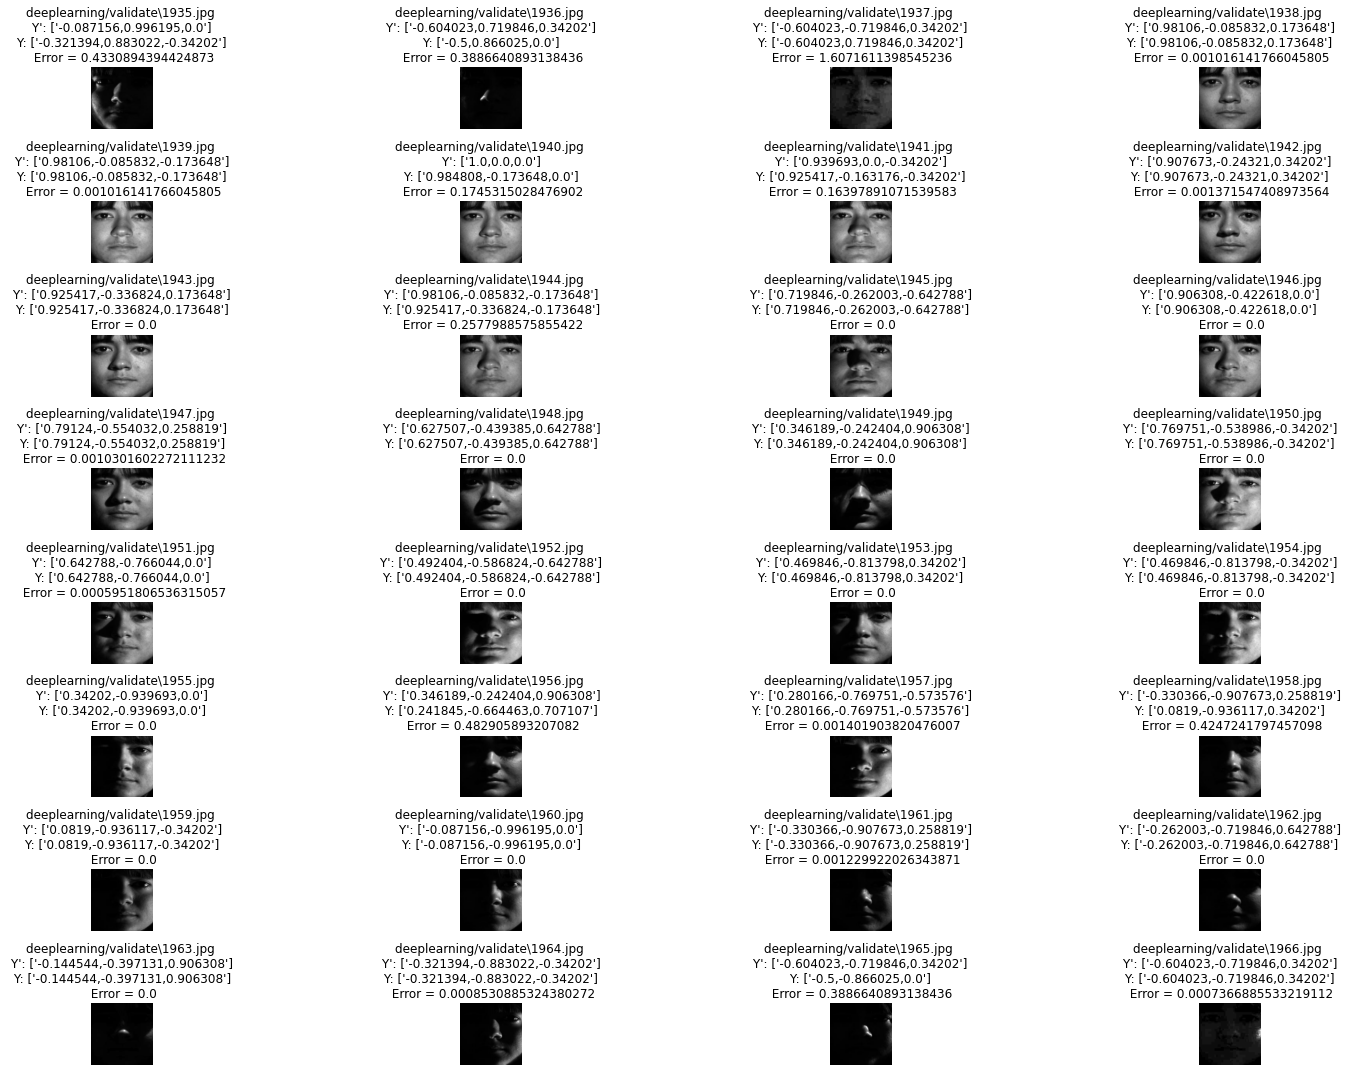

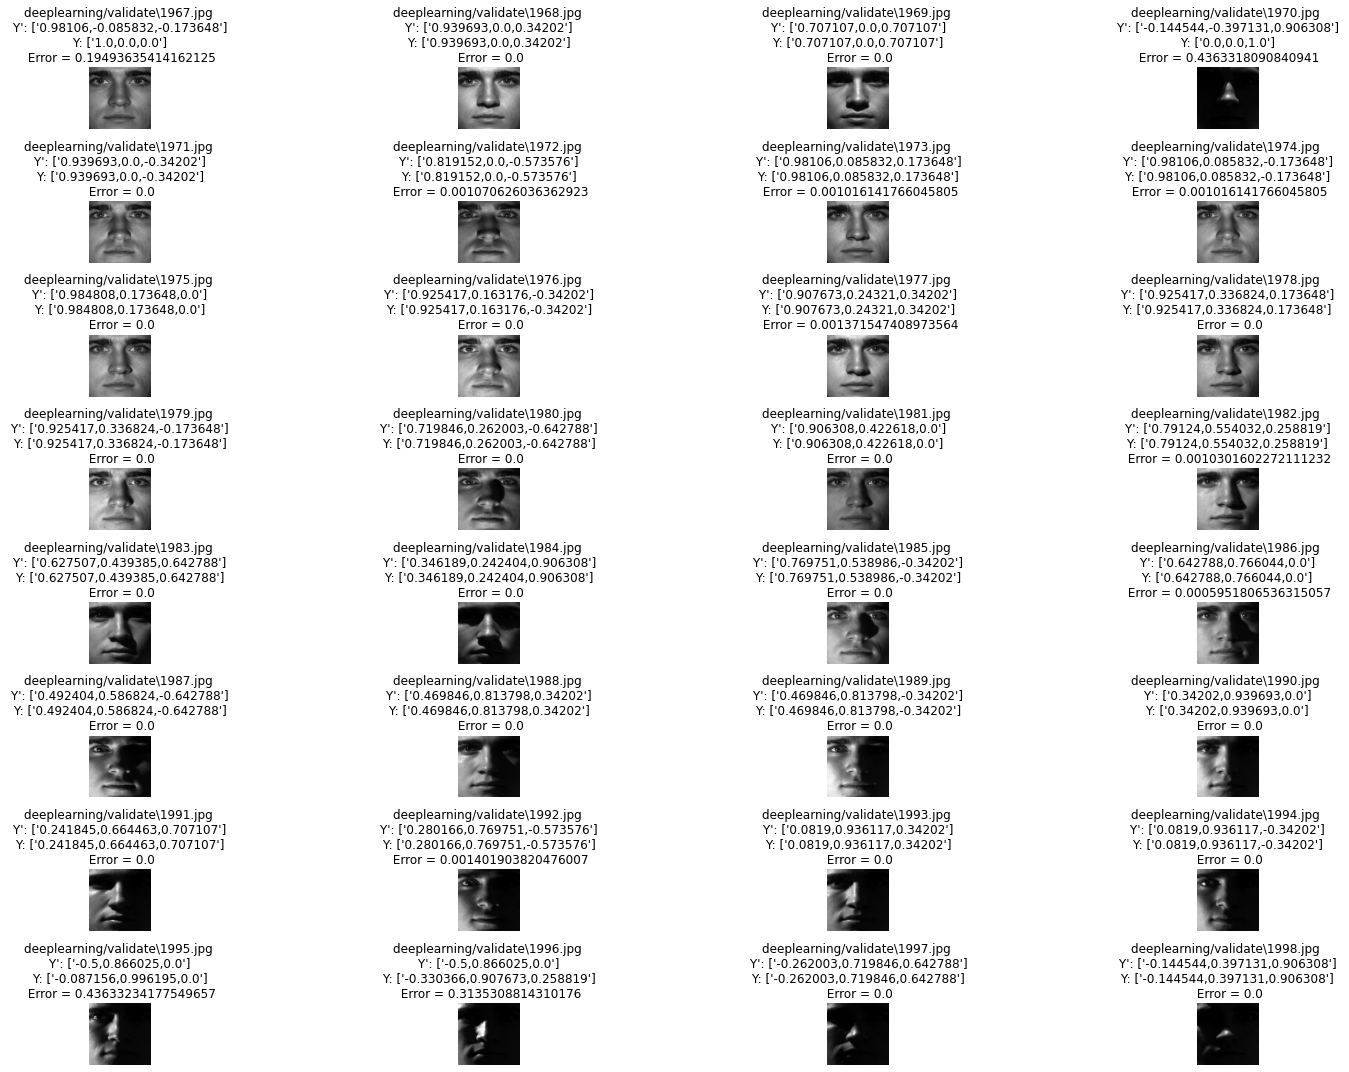

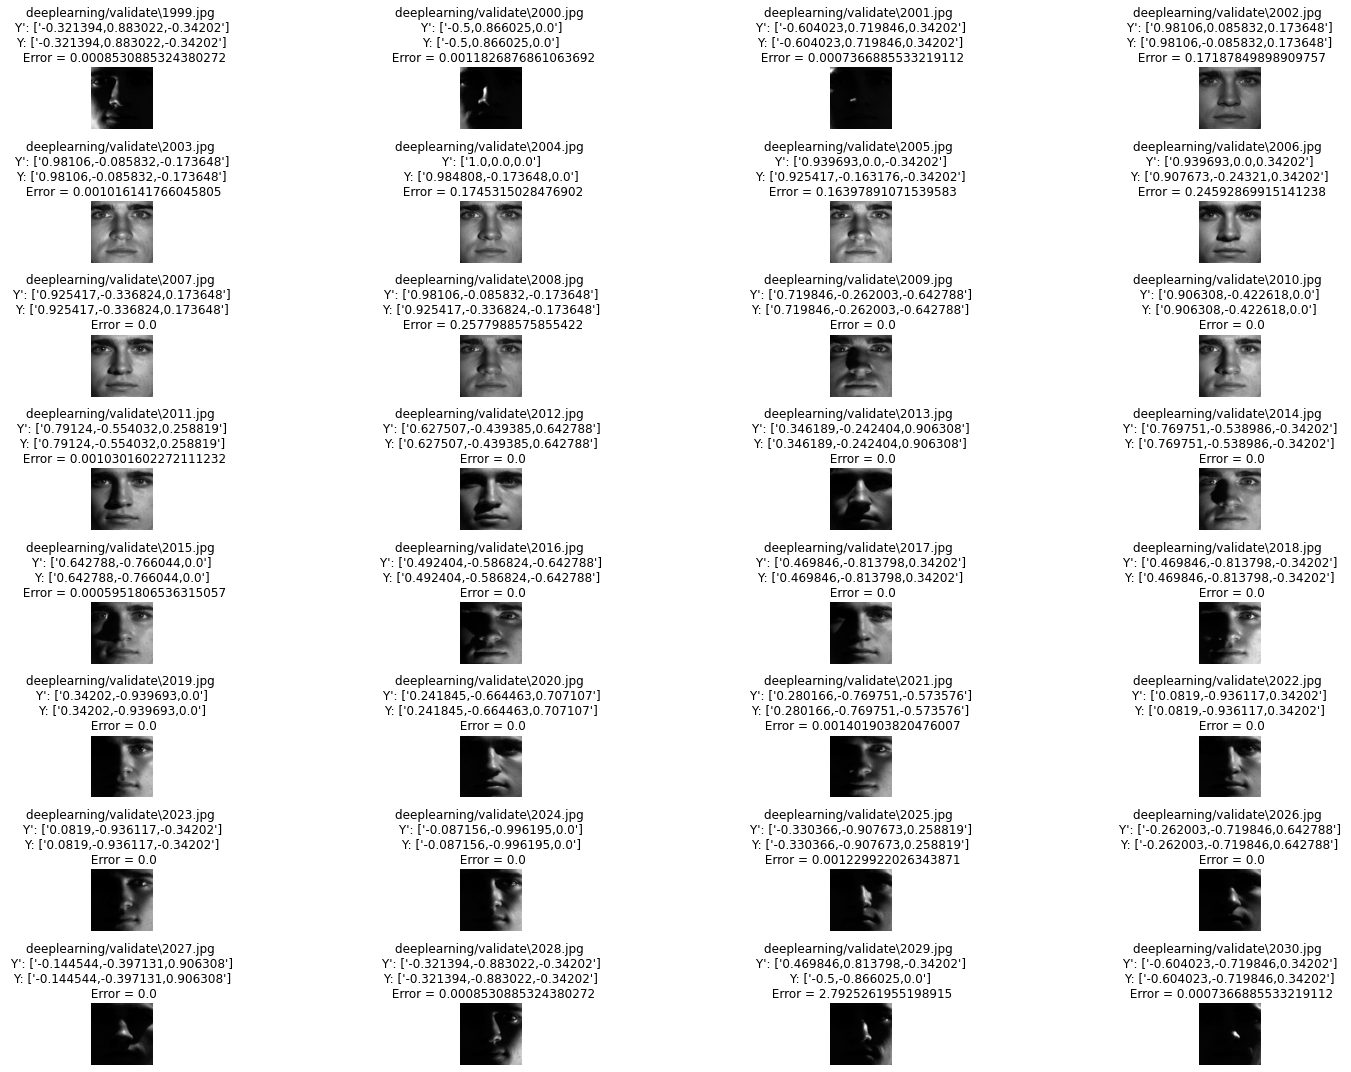

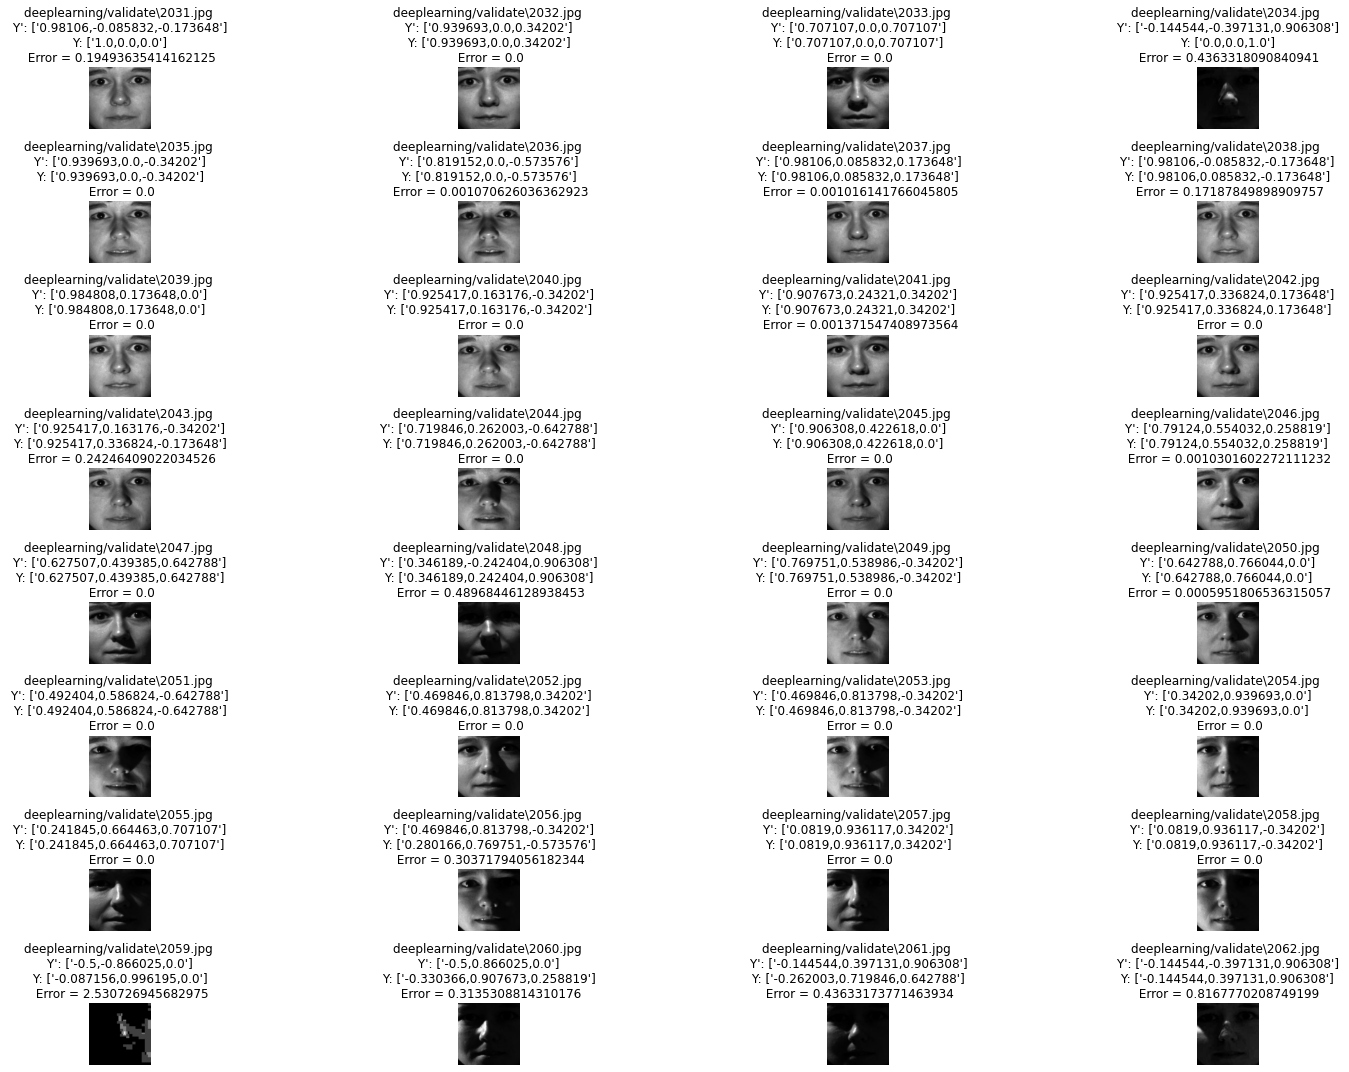

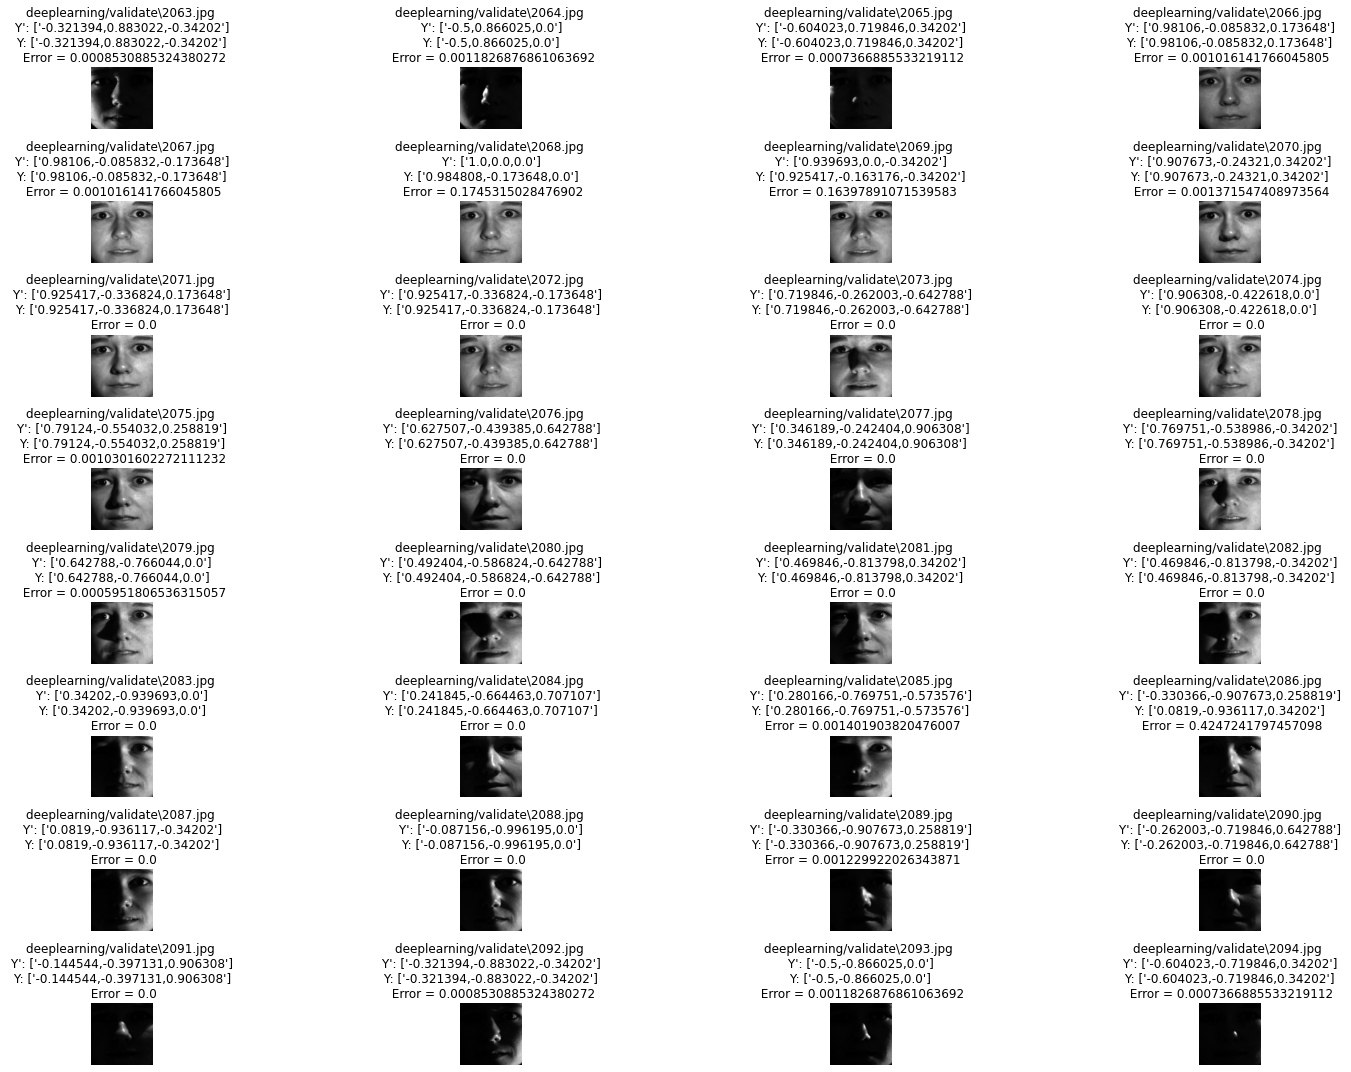

 Mean Angle Error for test set is :0.08


In [38]:
angle_errors = []
for index, (images, labels,image_names) in enumerate(test_dataloader):
    images,labels = images.to(device), labels.to(device)
    output = model(images)
    pred_y = torch.argmax(output, 1)
    figure = plt.figure(figsize=(30, 15))
    for i in range(32):
        figure.add_subplot(8, 4, i+1)
        error = torch.acos(torch.min(torch.tensor(1),torch.max(torch.tensor(-1),torch.dot(label_decode([pred_y[i].item()]),label_decode([labels[i].item()])))))
        angle_errors.append(error)
        plt.title(f"{image_names[i]} \n Y': {le.inverse_transform([pred_y[i].item()])} \n Y: {le.inverse_transform([labels[i].item()])} \n Error = {error}")
        plt.axis("off")
        plt.imshow(images[i,:].squeeze().cpu(), cmap="gray")
    figure.tight_layout()
    plt.tight_layout()
    plt.show()
error = sum(angle_errors)/len(angle_errors)
error = np.asarray(error)
print(f" Mean Angle Error for test set is :{np.round(error,2)}")

### Assessment Block

In [3]:
state_dict = torch.hub.load_state_dict_from_url('https://www-users.york.ac.uk/~sk1438/model_weights.pth')

Downloading: "https://www-users.york.ac.uk/~sk1438/model_weights.pth" to C:\Users\Sam/.cache\torch\hub\checkpoints\model_weights.pth


  0%|          | 0.00/3.65M [00:00<?, ?B/s]

In [34]:
test_dataset = FaceDataset(csv_file='deeplearning/validate/labels.csv',
                           image_dir='deeplearning/validate')

In [35]:
model = CNN()
model.load_state_dict(state_dict)
model.to(device)

CNN(
  (convlayers): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): MaxPool2d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
    (10): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
  (MLP): Sequential(
    (0): Linear(in_features=7776, out_features=120, bias=True)
    (1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=120, out_feature

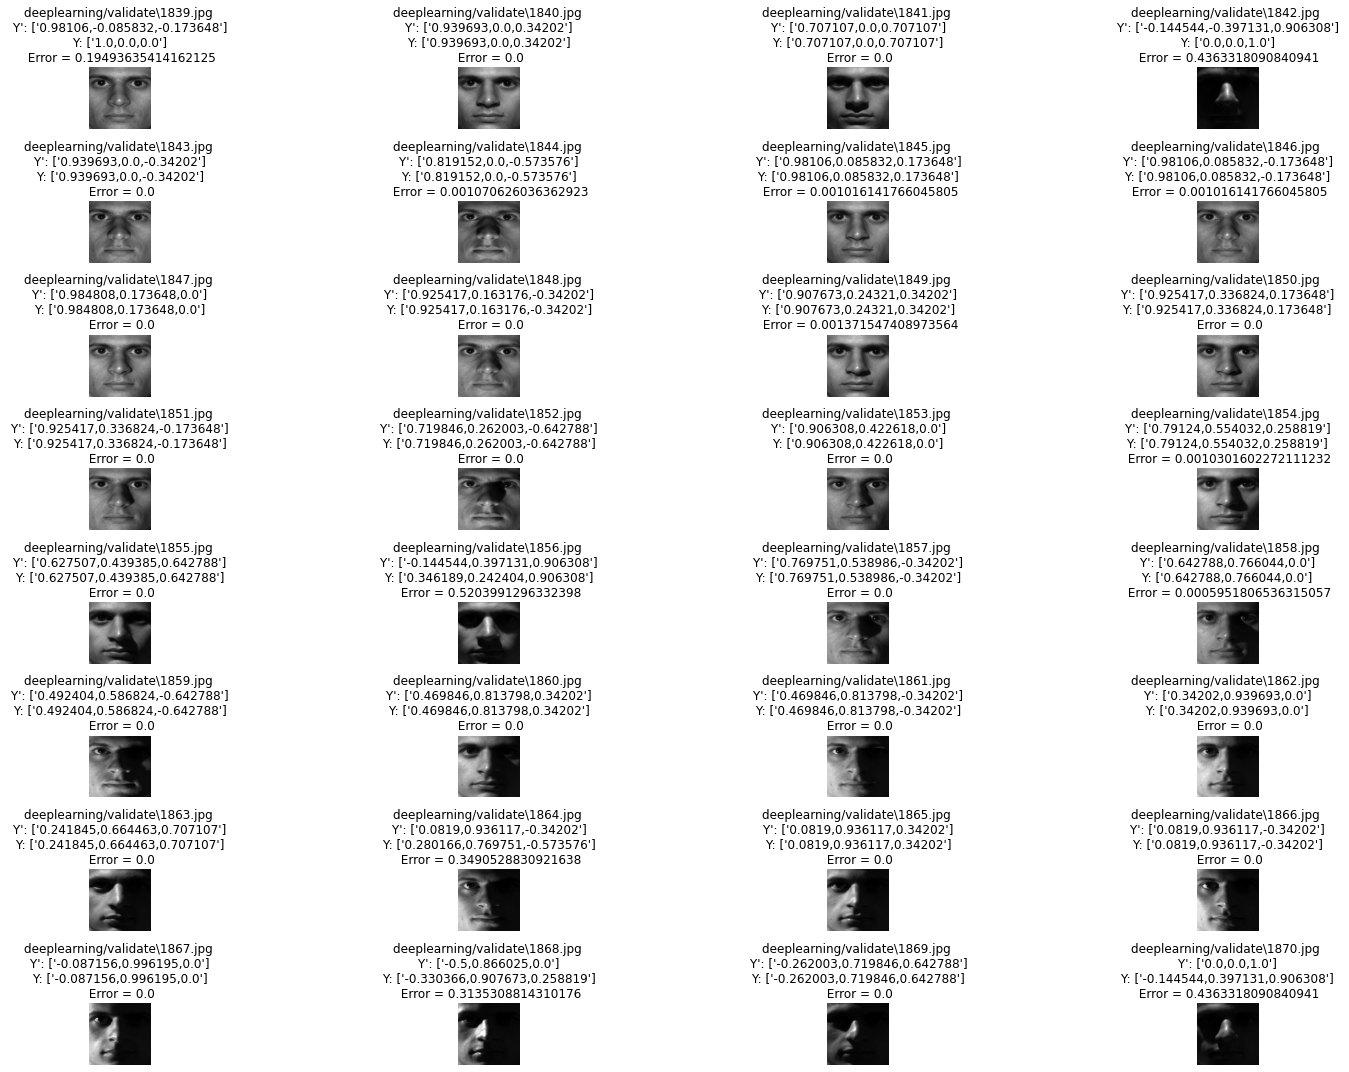

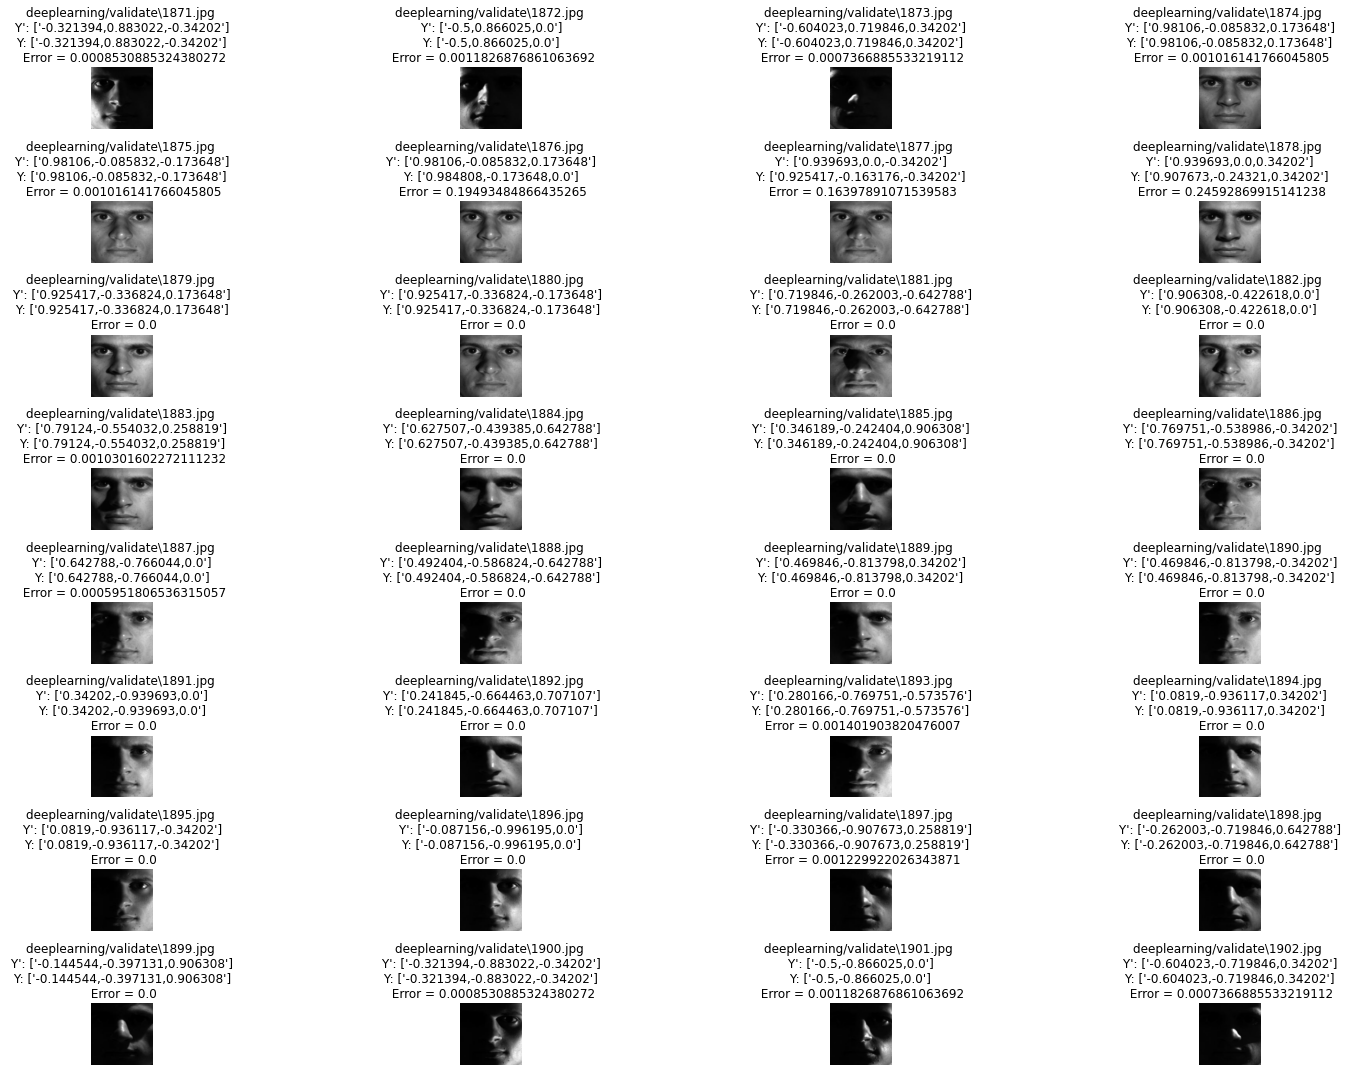

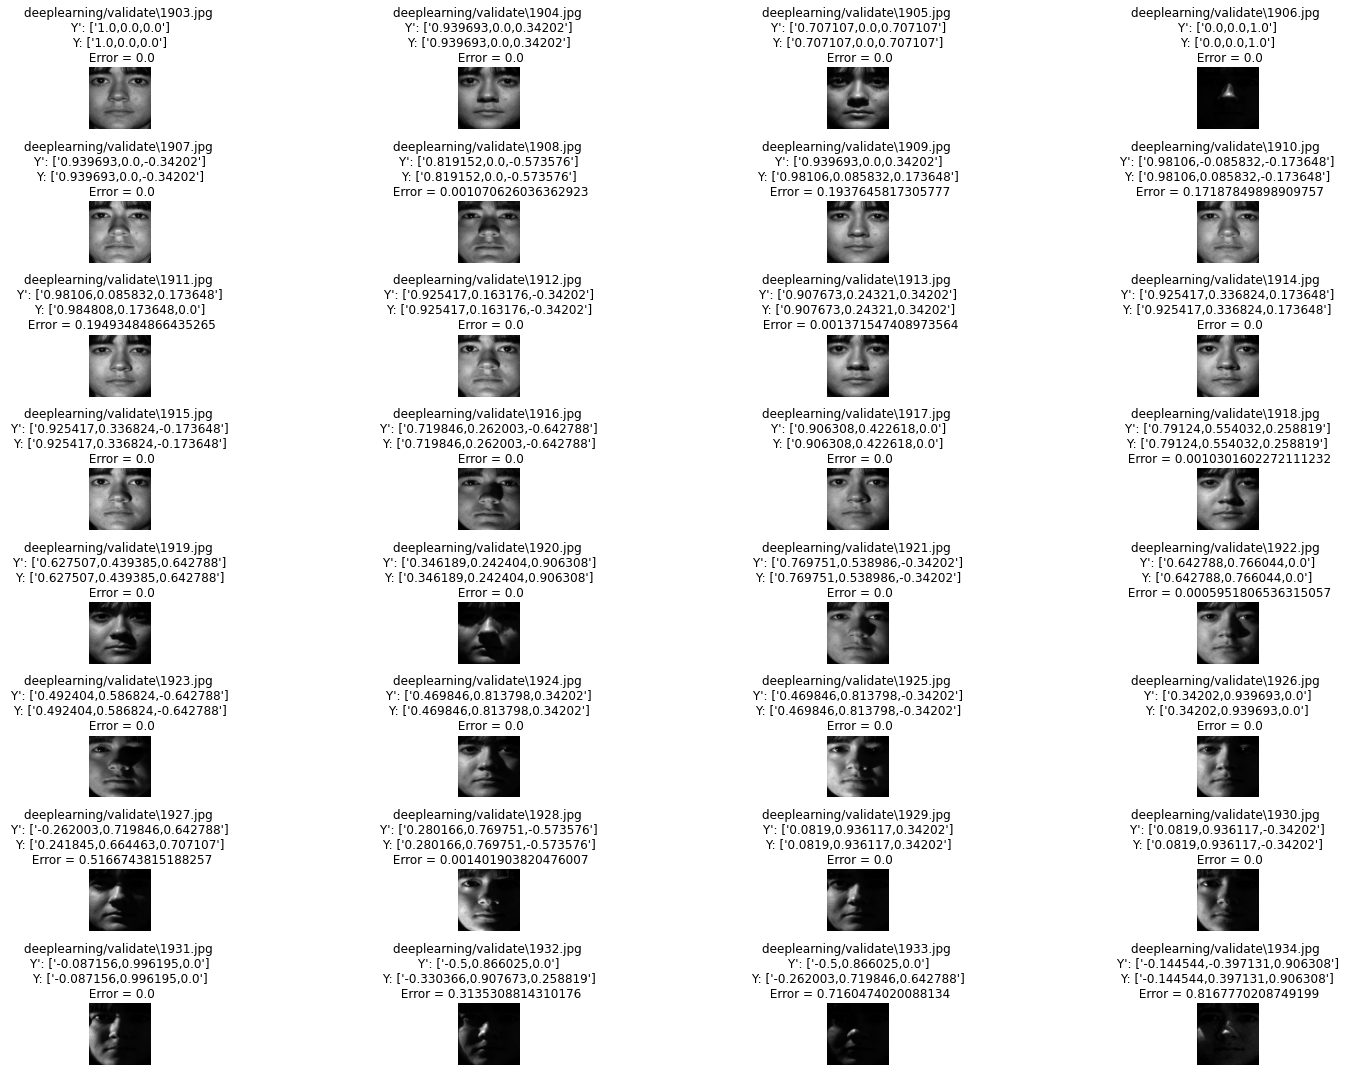

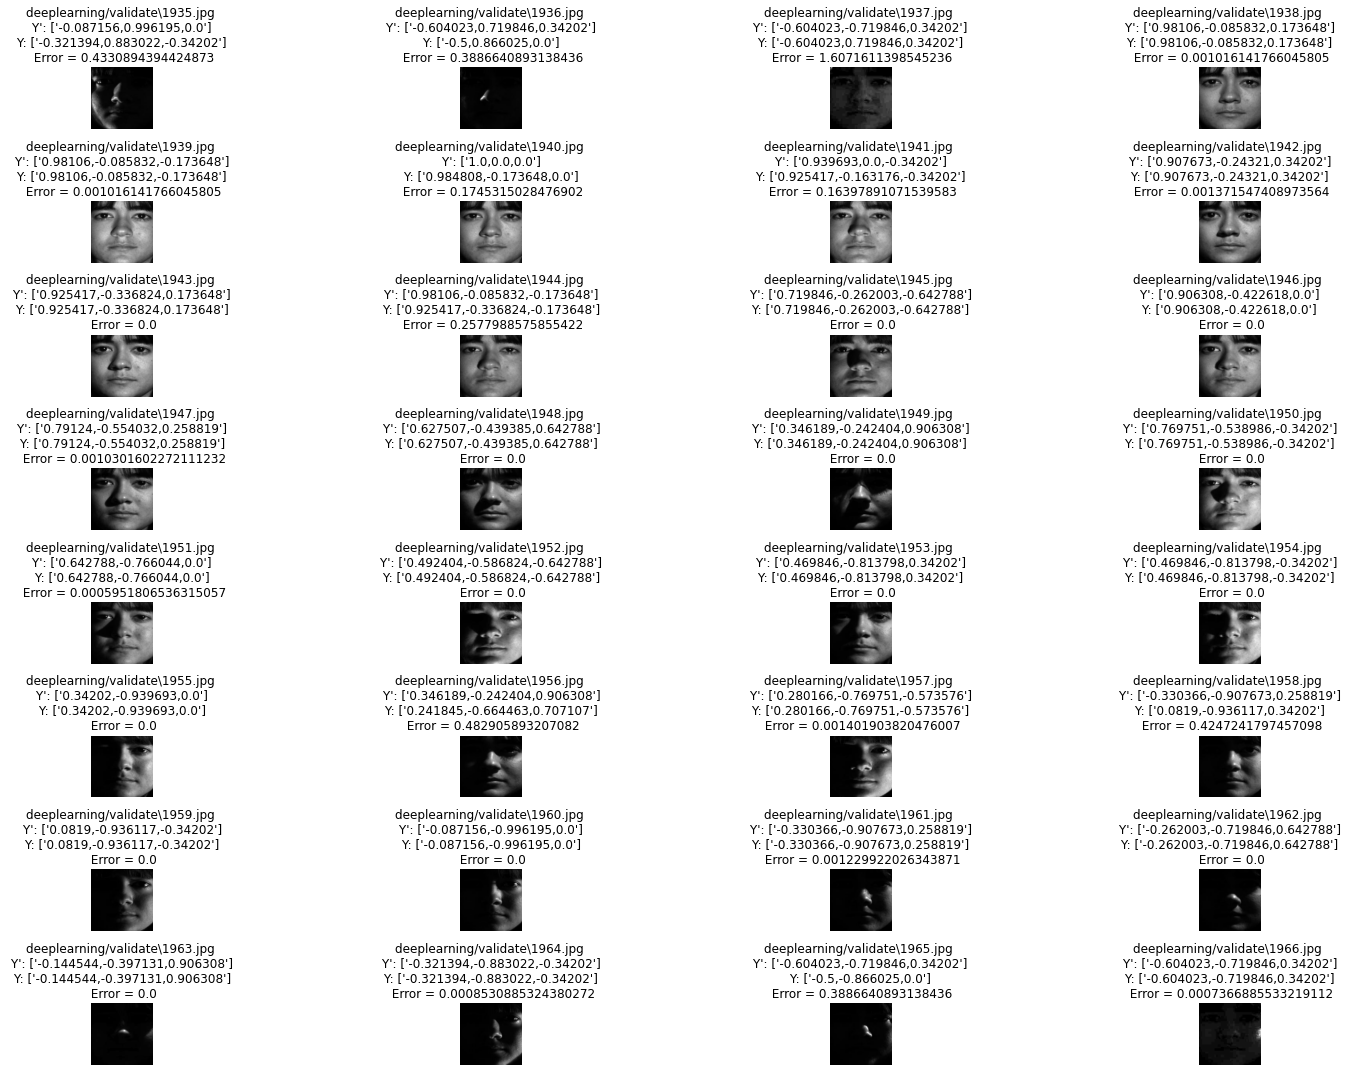

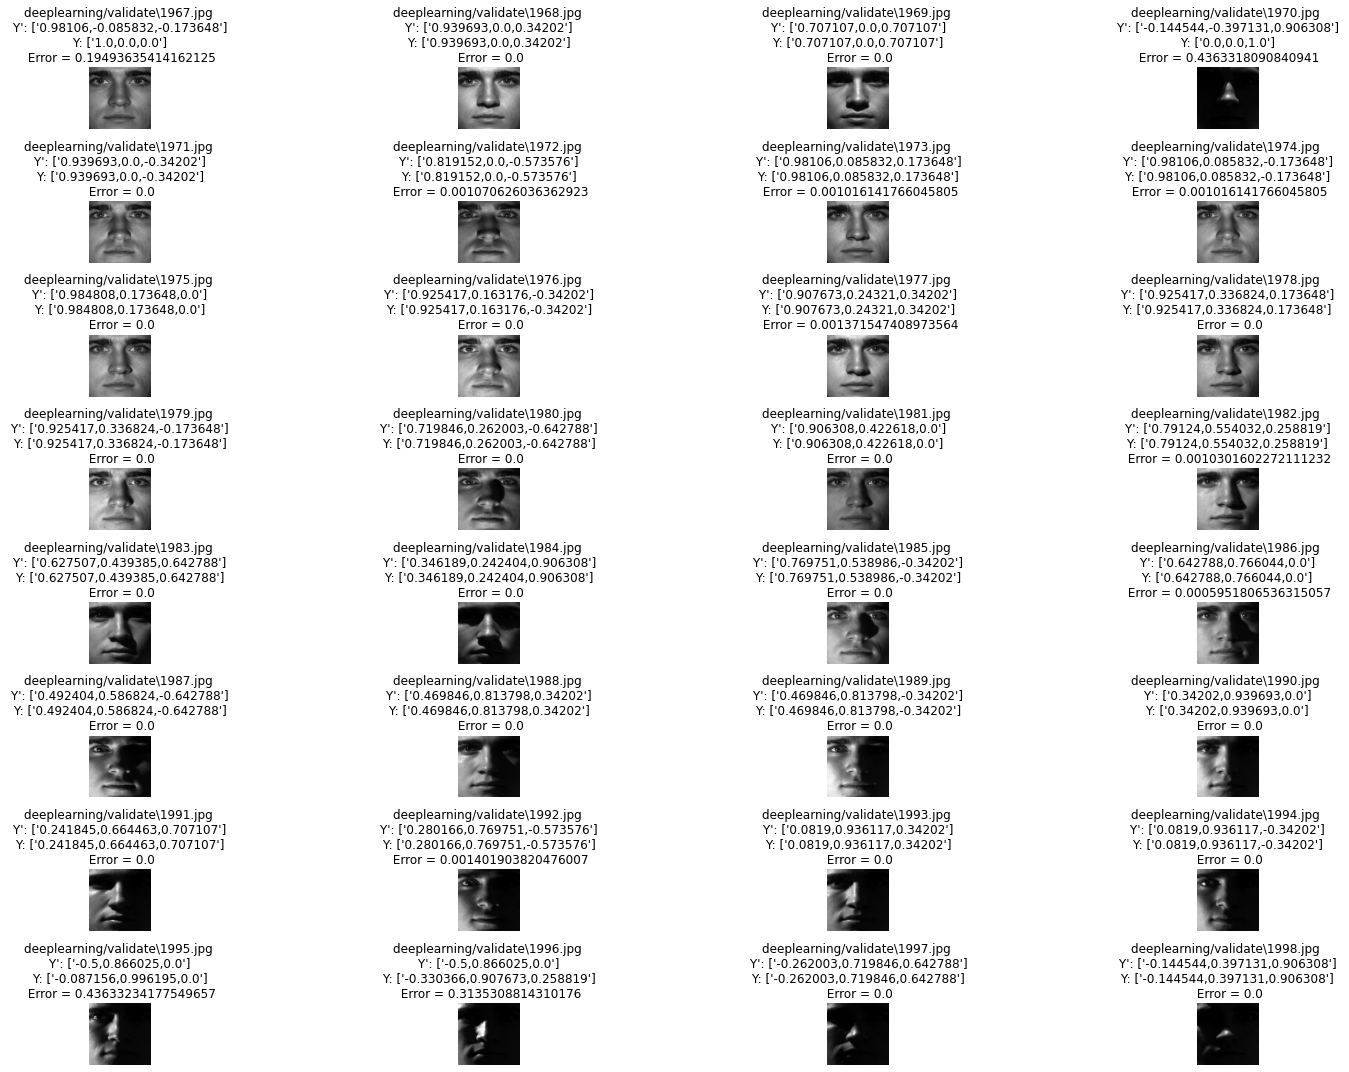

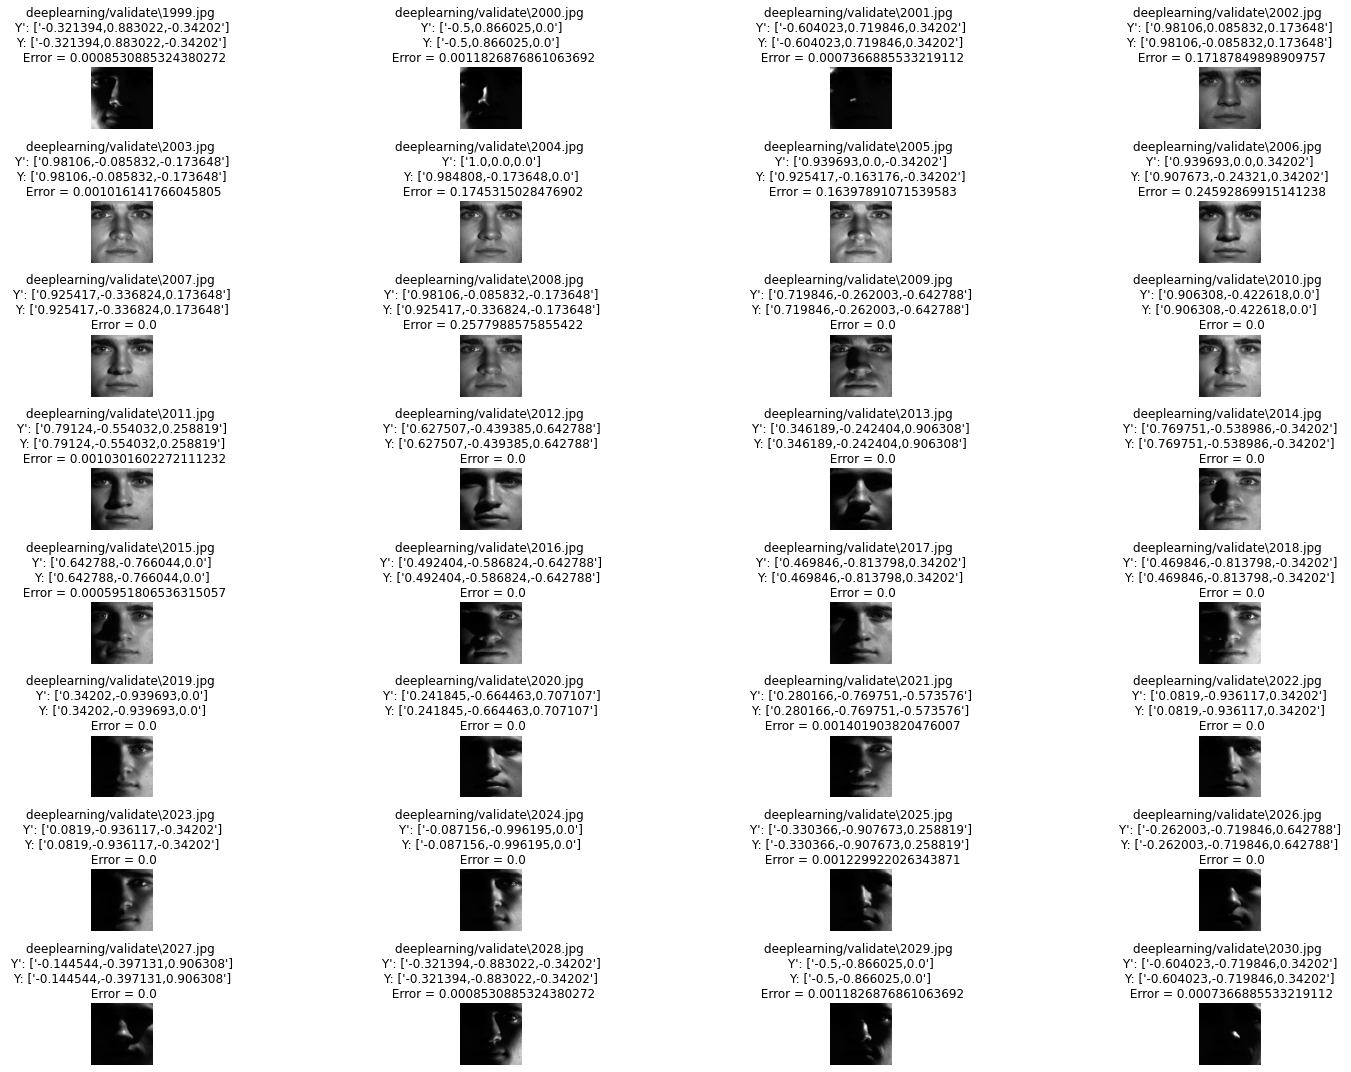

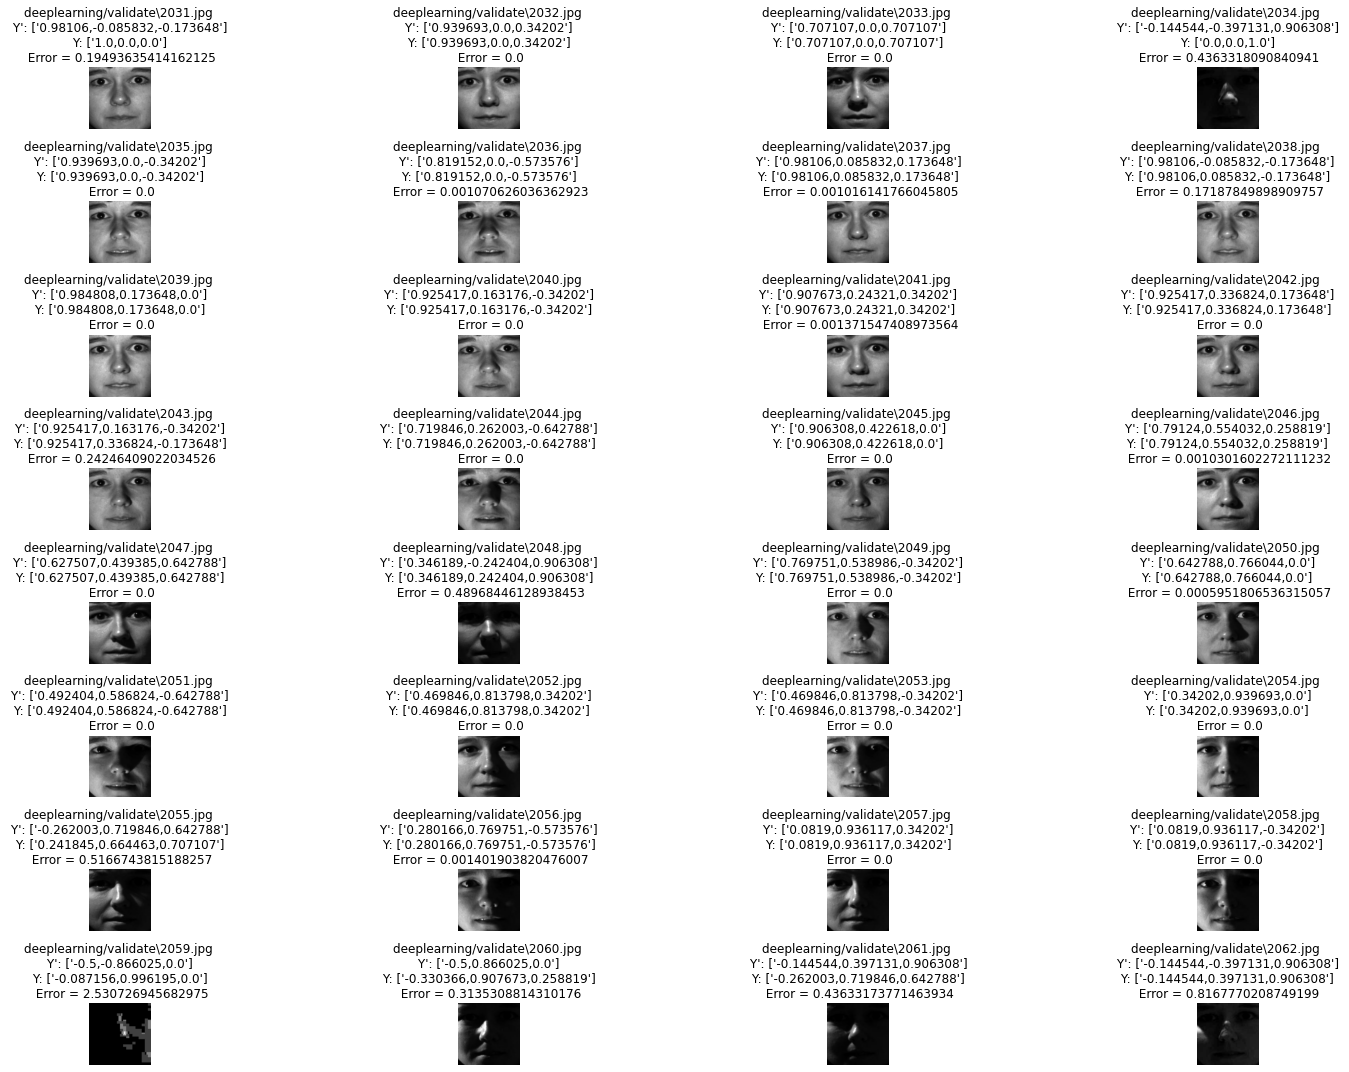

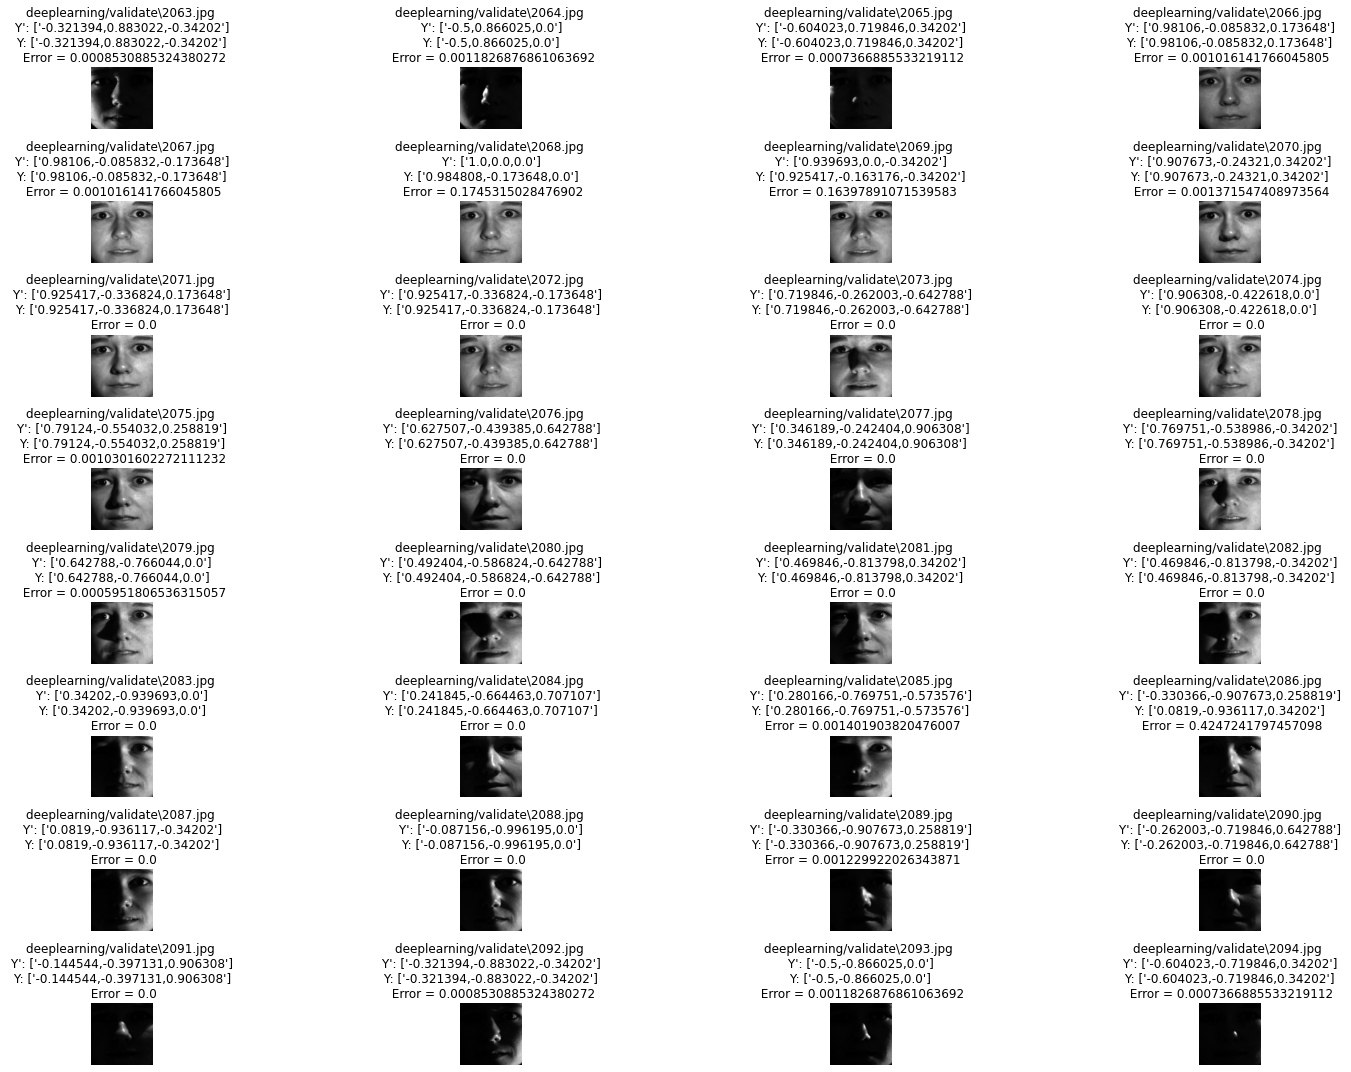

 Mean Angle Error for test set is :0.08


In [36]:
angle_errors = []
for index, (images, labels,image_names) in enumerate(test_dataloader):
    images,labels = images.to(device), labels.to(device)
    output = model(images)
    pred_y = torch.argmax(output, 1)
    figure = plt.figure(figsize=(30, 15))
    for i in range(32):
        figure.add_subplot(8, 4, i+1)
        error = torch.acos(torch.min(torch.tensor(1),torch.max(torch.tensor(-1),torch.dot(label_decode([pred_y[i].item()]),label_decode([labels[i].item()])))))
        angle_errors.append(error)
        plt.title(f"{image_names[i]} \n Y': {le.inverse_transform([pred_y[i].item()])} \n Y: {le.inverse_transform([labels[i].item()])} \n Error = {error}")
        plt.axis("off")
        plt.imshow(images[i,:].squeeze().cpu(), cmap="gray")
    figure.tight_layout()
    plt.tight_layout()
    plt.show()
error = sum(angle_errors)/len(angle_errors)
error = np.asarray(error)
print(f" Mean Angle Error for test set is :{np.round(error,2)}")

# 4 Generating face images with controllable lighting

In [ ]:
class FaceDataset(Dataset):
    """Custom Fashion MNIST dataset."""

    def __init__(self, csv_file, image_dir,):
        self.labels_df = pd.read_csv(csv_file,header=None)
        self.labels_df = encode_dataframe(self.labels_df)
        self.transform = transform
        self.image_dir = image_dir

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.image_dir,
                                self.labels_df.iloc[idx, 0])
        image = io.imread(img_name, as_gray=True)
        image = transform.resize(image,(128,128))
        convert_tensor = transforms.ToTensor()
        image = convert_tensor(image)
        image.unsqueeze(0)
        camera_position = torch.tensor(self.labels_df.iloc[idx, 4])
        camera_position =  camera_position.type(torch.LongTensor)





        return image.float(), camera_position,img_name

For the GAN I am introducing new hyperparameters:

ngf- A constant for the depth of the feautre maps in the generator
ndf - A constant for the depth of the feautre maps in the discriminator
nz - The length of the latent vector

The batch size started at 128 but during the development of the model I reduced it to 16 due to it leading to better images. There is generally a trade off between batch size and training time, since I had access to a GPU (RTX 2060) it made sense for me to sacrifice training time for accuracy, especially because the model does not need to be retrained and is saved for the assessment.

In [ ]:
# Define some parameters
batch_size = 16
nz = 100
ngf = 128
ndf = ngf
num_epochs = 10
lr = 0.0002
beta1 = 0.5


The generator is tasked with generating images that ressemble the training data. It is a function that maps the latent space to the vector space.
This is done through passing input through a multiple blocks of layers composing of a convolutional transpose a batch normalisation and a ReLU activation function.
It starts for 4x4 and doubles in height and width until reaching the desired dimension of 128x128

In [43]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(     nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 8 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 16 x 16
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d(    ngf,      1, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 128 x 128
        )

    def forward(self, input):
        return self.main(input)

netG = Generator()
netG = netG.to(device)

NameError: name 'nz' is not defined

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 128 x 128
            nn.Conv2d(1, ndf, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf * 4, ndf * 8, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

netD = Discriminator()
netD = netD.to(device)

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(8, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True))

        iters += 1

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Assessment

In [39]:
generator_state_dict = torch.hub.load_state_dict_from_url('https://www-users.york.ac.uk/~sk1438/generator.pth')

Downloading: "https://www-users.york.ac.uk/~sk1438/generator.pth" to C:\Users\Sam/.cache\torch\hub\checkpoints\generator.pth


  0%|          | 0.00/183M [00:00<?, ?B/s]

Downloading: "https://www-users.york.ac.uk/~sk1438/discrimiator" to C:\Users\Sam/.cache\torch\hub\checkpoints\discrimiator


HTTPError: HTTP Error 404: Not Found

In [41]:
discriminator_state_dict = torch.hub.load_state_dict_from_url('https://www-users.york.ac.uk/~sk1438/discriminator.pth')

Downloading: "https://www-users.york.ac.uk/~sk1438/discriminator.pth" to C:\Users\Sam/.cache\torch\hub\checkpoints\discriminator.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [42]:
netG.load_state_dict(generator_state_dict)
netD.load_state_dict(discriminator_state_dict)
netG.to(device)
netD.to(device)

NameError: name 'netG' is not defined

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
# Solution

nsamples = 7
z1 = torch.randn(1, nz, 1, 1, device=device)
z2 = torch.randn(1, nz, 1, 1, device=device)
z = torch.zeros(nsamples,nz,1,1,device=device)
for i in range(nsamples):
    w1 = i/(nsamples-1)
    w2 = 1-w1
    z[i,:,:,:] = w1*z1 + w2*z2
images = netG(z)

figure = plt.figure(figsize=(20, 20))
for i in range(nsamples):
    figure.add_subplot(1, nsamples, i+1)
    plt.axis("off")
    fake_image = np.transpose(images[i].detach().cpu(),(1,2,0))
    plt.imshow(fake_image, cmap="gray")
plt.show()